In [2]:
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(2, 4)
(101,)
(2, 101)


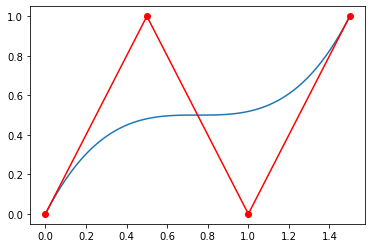

In [3]:
import bezier

nodes = np.asfortranarray([
    [0.0, 0.5, 1.0, 1.5],
    [0.0, 1.0, 0.0, 1.0],
])

print(nodes.shape)
curve = bezier.Curve(nodes, degree=3)

# Evaluate the curve at 101 points.
t = np.linspace(0.0, 1.0, 101)
print(t.shape)
evaluated = curve.evaluate_multi(t)


print(evaluated.shape)

# Plot the evaluated curve.
plt.plot(evaluated[0], evaluated[1])
plt.plot(nodes[0], nodes[1], "ro-")

plt.show()


(100, 2)
(7, 2)


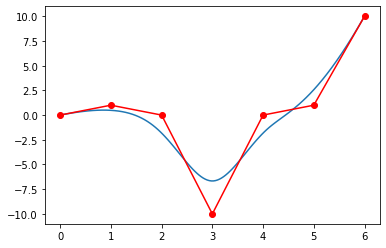

In [16]:
# Create a B-spline of Degree 3
k = 3
t = [0, 0,0, 0, 1, 2, 3, 4, 4 , 4, 4]
c = [[0,0],
        [1,1],
        [2,0],
        [3,-10],
        [4,0],
        [5,1],
        [6,10]
     ]
spl = BSpline(t, c, k)

# Evaluate the B-spline
x = np.linspace(0, 4, 100)
y = spl(x)

print(y.shape)

print(np.array(c).shape)
# Plot the B-spline
plt.plot(y[:,0], y[:,1])
# Plot the control points

c = np.array(c) 
plt.plot(c[:,0], c[:,1], "ro-")



plt.show()


In [22]:
# Define B-spline basis functions
def bspline_basis(t, i, k, knots):
    if k == 0:
        return 1.0 if knots[i] <= t < knots[i+1] else 0.0
    else:
        denom1 = knots[i+k] - knots[i]
        term1 = 0.0 if denom1 == 0.0 else (t - knots[i]) / denom1 * bspline_basis(t, i, k-1, knots)
        denom2 = knots[i+k+1] - knots[i+1]
        term2 = 0.0 if denom2 == 0.0 else (knots[i+k+1] - t) / denom2 * bspline_basis(t, i+1, k-1, knots)
        return term1 + term2

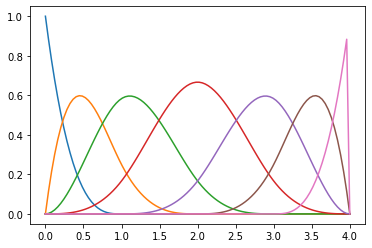

In [34]:
t = np.linspace(0, 4, 100)
knots = [0, 0, 0, 0, 1, 2, 3, 4, 4, 4, 4]
basis0 = np.array([bspline_basis(t_, 0, 3, knots) for t_ in t])
basis1 = np.array([bspline_basis(t_, 1, 3, knots) for t_ in t])
basis2 = np.array([bspline_basis(t_, 2, 3, knots) for t_ in t])
basis3 = np.array([bspline_basis(t_, 3, 3, knots) for t_ in t])
basis4 = np.array([bspline_basis(t_, 4, 3, knots) for t_ in t])
basis5 = np.array([bspline_basis(t_, 5, 3, knots) for t_ in t])
basis6 = np.array([bspline_basis(t_, 6, 3, knots) for t_ in t])


plt.plot(t, basis0, label="Basis 0")
plt.plot(t, basis1, label="Basis 1")
plt.plot(t, basis2, label="Basis 2")
plt.plot(t, basis3, label="Basis 3")
plt.plot(t, basis4, label="Basis 4")
plt.plot(t, basis5, label="Basis 5")
plt.plot(t, basis6, label="Basis 6")

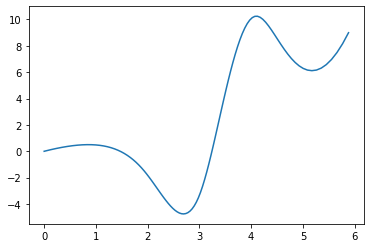

In [46]:
# casssssssssssslculate the B-spline curve
curve = np.zeros((len(t), 2))


c = np.array([[0,0],
        [1,1],
        [2,0],
        [3,-10],
        [4,20],
        [5,1],
        [6,10]    
    ])
for j, t_ in enumerate(t):
    for i in range(7):
        curve[j] += bspline_basis(t_, i, 3, knots) * c[i]   

plt.plot(curve[:-1,0], curve[:-1,1], label="B-spline curve")


In [77]:
#B-spline basis function as casssssadi symbolic expression
import casadi as cas


def bspline_basis(t, i, k, knots):
    if k == 0:
        return cas.if_else(cas.le(t, knots[i+1]), 1.0, 0.0)
    else:
        denom1 = knots[i+k] - knots[i]
        term1 = cas.if_else(cas.eq(denom1, 0.0), 0.0, (t - knots[i]) / denom1 * bspline_basis(t, i, k-1, knots))
        denom2 = knots[i+k+1] - knots[i+1]
        term2 = cas.if_else(cas.eq(denom2, 0.0), 0.0, (knots[i+k+1] - t) / denom2 * bspline_basis(t, i+1, k-1, knots))
        return term1 + term2


def bspline(t, c, k, knots):
    curve = cas.MX.zeros(2)
    for i in range(7):
        curve += bspline_basis(t, i, k, knots) * c[i]
    return curve

# Define Optimization problem

n_spline_points = 100

deg_spline = 3
knots = [0, 0, 0,0, 4, 4, 4, 4]
control_points = cas.SX.sym("control_points", 2, 2)

dec_vars = cas.vertcat(cas.vec(control_points))

# Define constraints
start_point = np.array([0, 0])
end_point = np.array([10, 6])

cons = cas.SX([])
lbg = []
ubg = []

# Start point constraint
cons = cas.vertcat(cons, (control_points[0,0] - start_point[0]) ** 2 + (control_points[0,1]  - start_point[1]) ** 2) # valid because the b spline is closed
lbg = np.concatenate((lbg, [0]))
ubg = np.concatenate((ubg, [0]))

# End point constraint
cons = cas.vertcat(cons, (control_points[1,0] - end_point[0]) ** 2 + (control_points[1,1]  - end_point[1]) ** 2) # valid because the b spline is closed
lbg = np.concatenate((lbg, [0]))
ubg = np.concatenate((ubg, [0]))

# Define objective
cost = cas.norm_2(control_points[0] - control_points[-1]) 

# Create Optimization problem
nlp = {"x": dec_vars, "f": cost, "g": cons}
solver = cas.nlpsol("solver", "ipopt", nlp)

# Solve Optimization problem
res = solver(lbg=lbg, ubg=ubg)

# Define the B-spline curve in scipy

sol_control_points = res["x"].reshape((2, 2)).T
print(sol_control_points)

spline = BSpline(knots, sol_control_points , deg_spline)

# Evaluate the B-spline curve
t = np.linspace(0, 4, n_spline_points)
curve = spline(t)

# Plot the B-spline curve
plt.plot(curve[:,0], curve[:,1], label="B-spline curve (casadi)")






This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        5

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.36e+02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

ValueError: Knots, coefficients and degree are inconsistent.